<a href="https://colab.research.google.com/github/Mostafa-babaee/Regression/blob/main/model_training_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install necessary packages
!pip install rdkit scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 17.1 MB/s eta 0:00:00


In [3]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

  Compound ID  Exp. Log Solubility (mol/lit)  \
0   Amigdalin                          -0.77   
1    Fenfuram                          -3.30   
2      citral                          -2.06   
3      Picene                          -7.87   
4   Thiophene                          -1.33   

                                              SMILES  
0  OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...  
1                             Cc1occc1C(=O)Nc2ccccc2  
2                               CC(C)=CCCC(C)=CC(=O)  
3                 c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43  
4                                            c1ccsc1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Compound ID                    1128 non-null   object 
 1   Exp. Log Solubility (mol/lit)  1128 non-null   float64
 2   SMILES                        

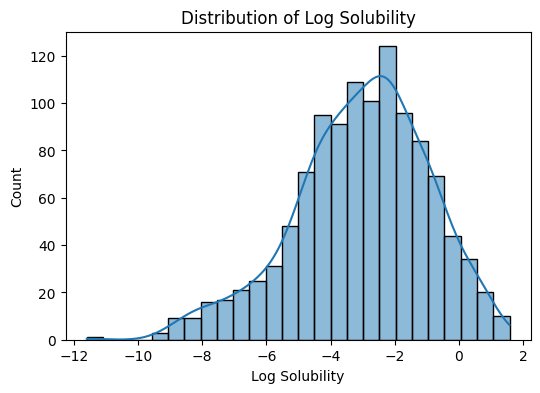

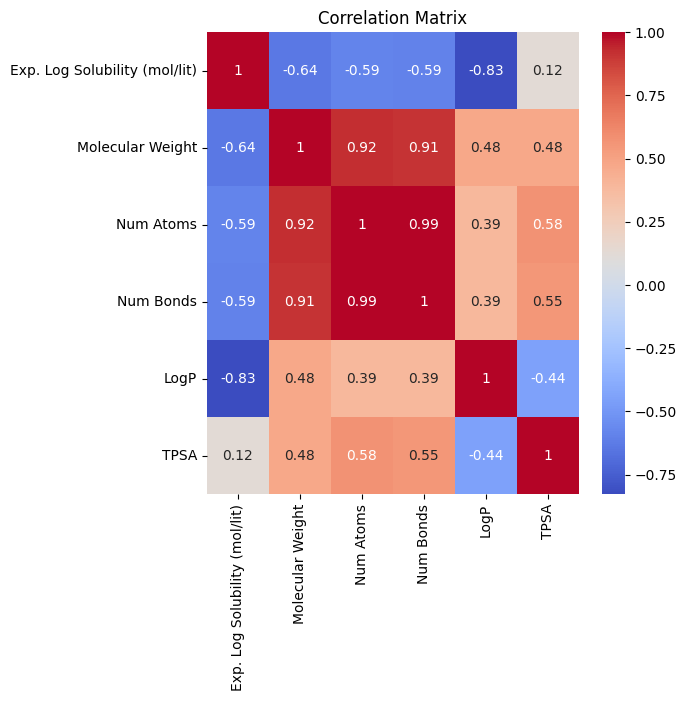

In [5]:
# Load our dataset
data = pd.read_csv('ESOL-processed.csv')

# Let's get some information about our data
print(data.head())
print(data.info())
print(data.describe())

# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

# Histogram distribution of our target variable (Exp. Log Solubility)
plt.figure(figsize=(6, 4))
sns.histplot(data['Exp. Log Solubility (mol/lit)'], kde=True)
plt.title('Distribution of Log Solubility')
plt.xlabel('Log Solubility')
plt.show()

# Generate molecular descriptors using the rdkit package
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mol_weight = Descriptors.MolWt(mol)
        num_atoms = mol.GetNumAtoms()
        num_bonds = mol.GetNumBonds()
        log_p = Descriptors.MolLogP(mol)
        TPSA = rdMolDescriptors.CalcTPSA(mol)
        return pd.Series([mol_weight, num_atoms, num_bonds, log_p, TPSA])
    else:
        return pd.Series([None, None, None, None])

# Add generated molecular descriptors to our dataframe
data[['Molecular Weight', 'Num Atoms', 'Num Bonds', 'LogP', 'TPSA']] = data['SMILES'].apply(calculate_descriptors)

# Correlation analysis
plt.figure(figsize=(6, 6))
numerical_data = data.select_dtypes(include=['number'])
sns.heatmap(numerical_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Training Regression Models Using the Most Common Models

In [6]:
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [7]:
# Instantiate the Morgan molecular Fingerprint Generation
morgan_gen = AllChem.GetMorganGenerator(radius=2, fpSize=2048)

# Function to compute molecular fingerprints using MorganGenerator
def calculate_fingerprints(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = morgan_gen.GetFingerprint(mol)
        return np.array(fp)
    else:
        return np.zeros(2048)

# Let's add generated fingerprints to our dataframe
X = np.array([calculate_fingerprints(smiles) for smiles in data['SMILES']])
y = data['Exp. Log Solubility (mol/lit)']

# function for model training and evaluation
def evaluate_model(model, model_name, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X, y, cv=kf)

    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

     # Plotting
    plt.figure(figsize=(4, 4))
    plt.scatter(y, y_pred, edgecolor='k', alpha=0.7)
    plt.plot([min(y), max(y)], [min(y), max(y)], color='r', linestyle='--')
    plt.title(f'{model_name} \n MSE: {mse:.3f}, R²: {r2:.3f}')
    plt.xlabel('Actual Log Solubility')
    plt.ylabel('Predicted Log Solubility')
    plt.show()

    return mse, r2

Using RDKit Morgan Molecular Fingerprints as Descriptors

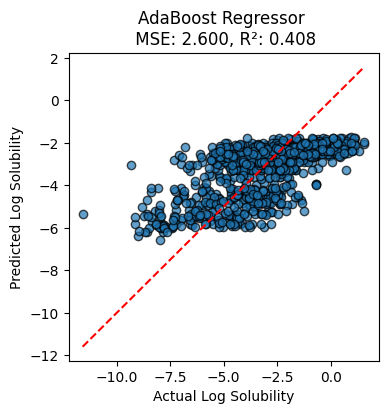

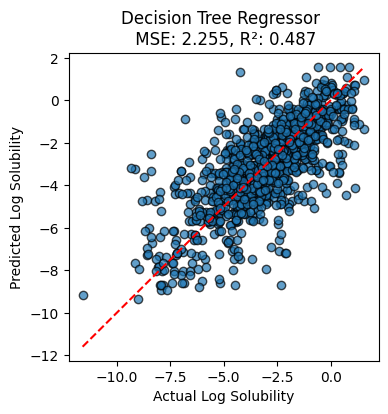

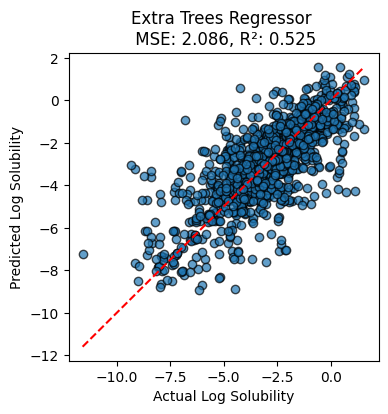

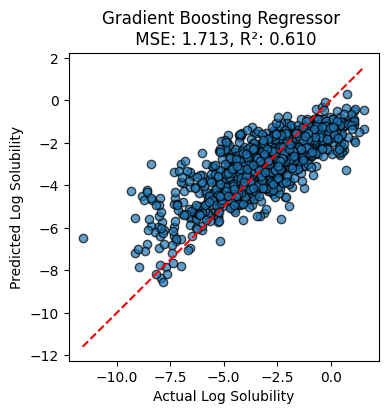

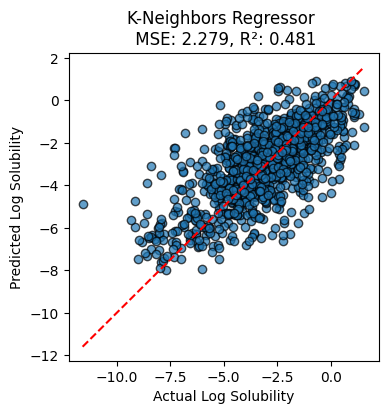

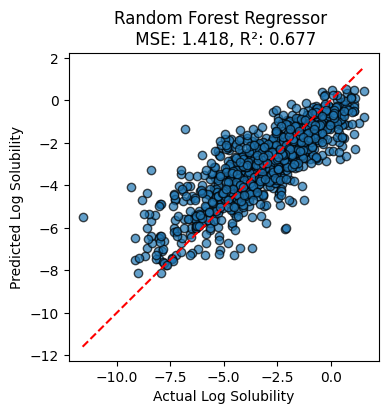

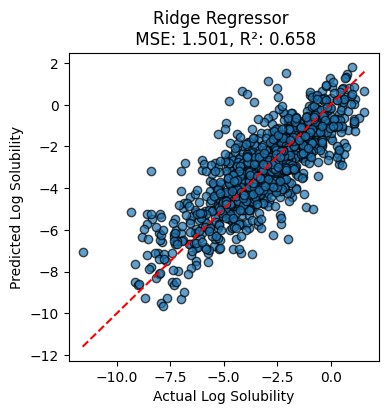

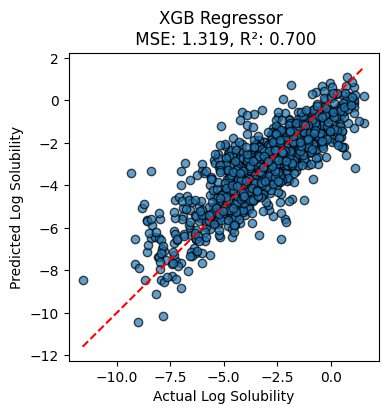

(1.3190732160571281, 0.699607759994708)

In [8]:
# AdaBoostRegressor
ada_model = AdaBoostRegressor()
evaluate_model(ada_model, 'AdaBoost Regressor', X=X, y=y)

# DecisionTreeRegressor
dt_model = DecisionTreeRegressor()
evaluate_model(dt_model, 'Decision Tree Regressor', X=X, y=y)

# ExtraTreesRegressor
et_model = ExtraTreesRegressor()
evaluate_model(et_model, 'Extra Trees Regressor', X=X, y=y)

# GradientBoostingRegressor
gb_model = GradientBoostingRegressor()
evaluate_model(gb_model, 'Gradient Boosting Regressor', X=X, y=y)

# KNeighborsRegressor
knn_model = KNeighborsRegressor()
evaluate_model(knn_model, 'K-Neighbors Regressor', X=X, y=y)

# RandomForestRegressor
rf_model = RandomForestRegressor()
evaluate_model(rf_model, 'Random Forest Regressor', X=X, y=y)

# Ridge
ridge_model = Ridge()
evaluate_model(ridge_model, 'Ridge Regressor', X=X, y=y)

# XGBRegressor
xgb_model = XGBRegressor()
evaluate_model(xgb_model, 'XGB Regressor', X=X, y=y)

Using RDKit Molecular Properties as Descriptors

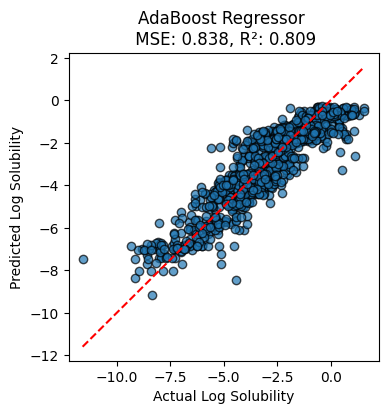

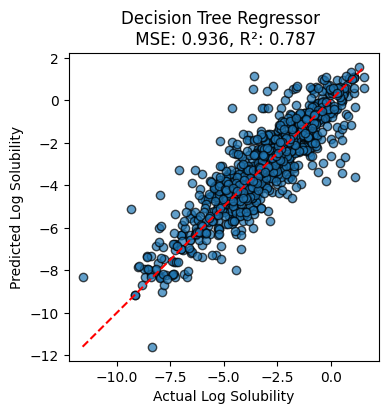

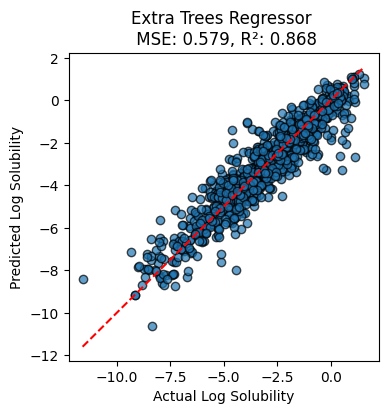

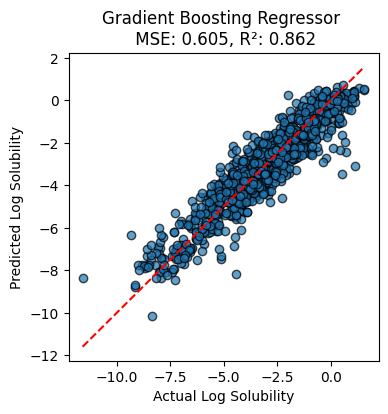

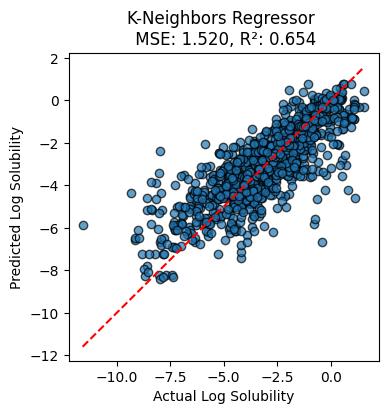

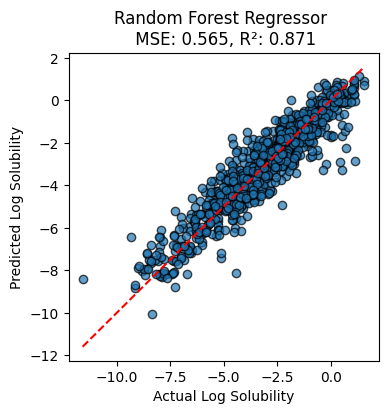

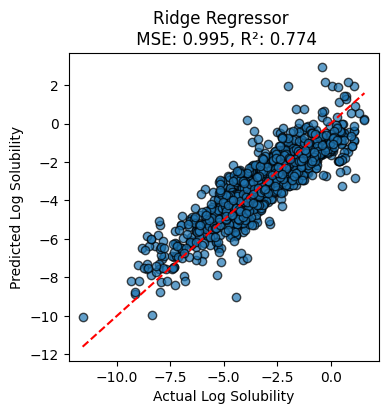

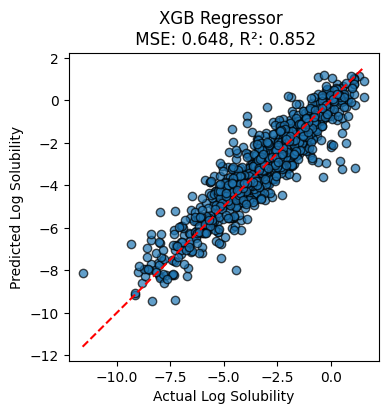

(0.6482732510001663, 0.8523688817020003)

In [9]:
# Select molecular properties as features
X_properties = data[['Molecular Weight', 'Num Atoms', 'Num Bonds', 'LogP']].values

# AdaBoostRegressor
ada_model = AdaBoostRegressor()
evaluate_model(ada_model, 'AdaBoost Regressor', X=X_properties, y=y)

# DecisionTreeRegressor
dt_model = DecisionTreeRegressor()
evaluate_model(dt_model, 'Decision Tree Regressor', X=X_properties, y=y)

# ExtraTreesRegressor
et_model = ExtraTreesRegressor()
evaluate_model(et_model, 'Extra Trees Regressor', X=X_properties, y=y)

# GradientBoostingRegressor
gb_model = GradientBoostingRegressor()
evaluate_model(gb_model, 'Gradient Boosting Regressor', X=X_properties, y=y)

# KNeighborsRegressor
knn_model = KNeighborsRegressor()
evaluate_model(knn_model, 'K-Neighbors Regressor', X=X_properties, y=y)

# RandomForestRegressor
rf_model = RandomForestRegressor()
evaluate_model(rf_model, 'Random Forest Regressor', X=X_properties, y=y)

# Ridge
ridge_model = Ridge()
evaluate_model(ridge_model, 'Ridge Regressor', X=X_properties, y=y)
# XGBRegressor
xgb_model = XGBRegressor()
evaluate_model(xgb_model, 'XGB Regressor', X=X_properties, y=y)

Training A Graph Neural Network (GNN) Regression Model

In [10]:
# Install PyTorch Geometric Packages
!pip install torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.6 MB/s eta 0:00:00


In [11]:
# Import necessary libs
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit.Chem import rdmolops

In [12]:
# Load our dataset
data = pd.read_csv('ESOL-processed.csv')

# Function to convert SMILES to PyTorch Geometric Data object (graph)
def mol_to_graph(smiles, target):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Convert atoms into node features
    atom_features = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.float).view(-1, 1)

    # Create edge index (connectivity between atoms)
    edge_index = rdmolops.GetAdjacencyMatrix(mol)
    edge_index = torch.tensor(np.nonzero(edge_index), dtype=torch.long)

    # Create PyTorch Geometric data object
    graph_data = Data(x=atom_features, edge_index=edge_index, y=torch.tensor([target], dtype=torch.float))
    return graph_data

# Create a dataset of graphs and targets
graph_data_list = []
for smiles, solubility in zip(data['SMILES'], data['Exp. Log Solubility (mol/lit)']):
    graph_data = mol_to_graph(smiles, solubility)
    if graph_data is not None:
        graph_data_list.append(graph_data)

# Split the dataset into 5 folds for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define our GNN model
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = Sequential(Linear(hidden_channels, 64), ReLU(), Linear(64, 1))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, data.batch)
        x = self.fc(x)
        return x

# Functions for training and evaluation
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            out = model(data)
            y_true.extend(data.y.view(-1).tolist())
            y_pred.extend(out.view(-1).tolist())
            loss = criterion(out, data.y.view(-1, 1))
            total_loss += loss.item()

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return total_loss / len(loader), mse, r2, y_true, y_pred


<ipython-input-12-ecaa37a4a078>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor(np.nonzero(edge_index), dtype=torch.long)


Fold 1
Epoch 0, Train Loss: 7.8799, Test Loss: 5.6802
Epoch 10, Train Loss: 4.6106, Test Loss: 5.4792
Epoch 20, Train Loss: 4.3343, Test Loss: 5.3010
Epoch 30, Train Loss: 4.5069, Test Loss: 5.2819
Epoch 40, Train Loss: 4.1533, Test Loss: 5.3160
Epoch 50, Train Loss: 4.2232, Test Loss: 5.2417
Epoch 60, Train Loss: 4.2358, Test Loss: 5.1128
Epoch 70, Train Loss: 4.1883, Test Loss: 5.0127
Epoch 80, Train Loss: 4.2097, Test Loss: 5.6323
Epoch 90, Train Loss: 4.0649, Test Loss: 5.0410
Epoch 100, Train Loss: 4.0757, Test Loss: 5.1617
Epoch 110, Train Loss: 4.0894, Test Loss: 4.9628
Epoch 120, Train Loss: 4.1035, Test Loss: 4.9195
Epoch 130, Train Loss: 4.0455, Test Loss: 4.8440
Epoch 140, Train Loss: 4.0308, Test Loss: 4.9764
Epoch 150, Train Loss: 4.2870, Test Loss: 4.8922
Epoch 160, Train Loss: 4.0458, Test Loss: 4.8435
Epoch 170, Train Loss: 3.9662, Test Loss: 4.9377
Epoch 180, Train Loss: 4.0263, Test Loss: 4.7605
Epoch 190, Train Loss: 3.9558, Test Loss: 4.6884
Epoch 200, Train Loss: 3

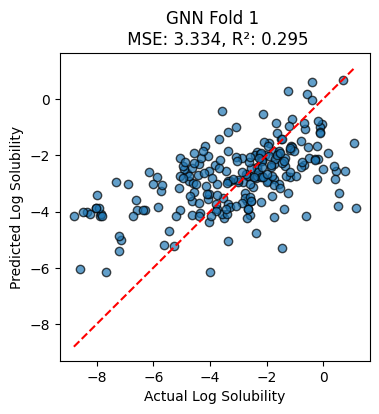

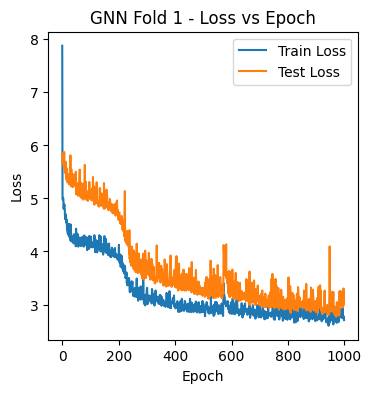

Fold 2
Epoch 0, Train Loss: 8.8165, Test Loss: 4.5040
Epoch 10, Train Loss: 4.8366, Test Loss: 4.3728
Epoch 20, Train Loss: 4.4565, Test Loss: 4.2420
Epoch 30, Train Loss: 4.5132, Test Loss: 4.4166
Epoch 40, Train Loss: 4.4711, Test Loss: 4.0243
Epoch 50, Train Loss: 4.4042, Test Loss: 4.0116
Epoch 60, Train Loss: 4.3782, Test Loss: 4.0221
Epoch 70, Train Loss: 4.3773, Test Loss: 3.9648
Epoch 80, Train Loss: 4.4249, Test Loss: 4.0411
Epoch 90, Train Loss: 4.6195, Test Loss: 3.9849
Epoch 100, Train Loss: 4.5108, Test Loss: 3.9226
Epoch 110, Train Loss: 4.3530, Test Loss: 3.9575
Epoch 120, Train Loss: 4.4367, Test Loss: 3.9235
Epoch 130, Train Loss: 4.2944, Test Loss: 3.9819
Epoch 140, Train Loss: 4.3646, Test Loss: 3.9437
Epoch 150, Train Loss: 4.3310, Test Loss: 3.8566
Epoch 160, Train Loss: 4.5131, Test Loss: 3.8448
Epoch 170, Train Loss: 4.3132, Test Loss: 3.8710
Epoch 180, Train Loss: 4.3457, Test Loss: 3.8511
Epoch 190, Train Loss: 4.3411, Test Loss: 3.8288
Epoch 200, Train Loss: 4

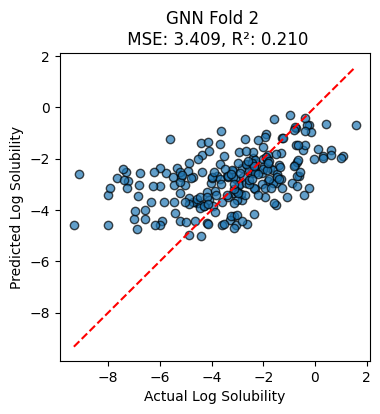

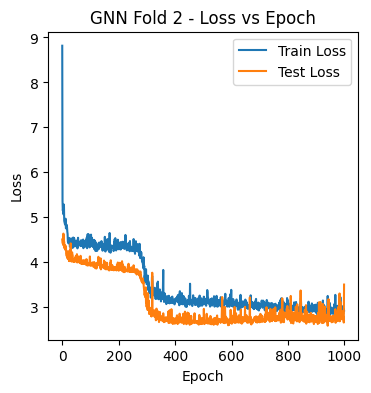

Fold 3
Epoch 0, Train Loss: 7.2556, Test Loss: 5.7864
Epoch 10, Train Loss: 4.7534, Test Loss: 5.2736
Epoch 20, Train Loss: 4.4872, Test Loss: 4.7743
Epoch 30, Train Loss: 4.6103, Test Loss: 4.4309
Epoch 40, Train Loss: 4.7025, Test Loss: 4.3957
Epoch 50, Train Loss: 4.4413, Test Loss: 4.3425
Epoch 60, Train Loss: 4.4875, Test Loss: 4.3967
Epoch 70, Train Loss: 4.5241, Test Loss: 4.2925
Epoch 80, Train Loss: 4.5986, Test Loss: 4.3255
Epoch 90, Train Loss: 4.3466, Test Loss: 4.2263
Epoch 100, Train Loss: 4.3613, Test Loss: 4.2254
Epoch 110, Train Loss: 4.4612, Test Loss: 4.1786
Epoch 120, Train Loss: 4.2933, Test Loss: 4.1625
Epoch 130, Train Loss: 4.5825, Test Loss: 4.3012
Epoch 140, Train Loss: 4.4260, Test Loss: 4.2091
Epoch 150, Train Loss: 4.4567, Test Loss: 4.1330
Epoch 160, Train Loss: 4.3815, Test Loss: 4.1587
Epoch 170, Train Loss: 4.2568, Test Loss: 4.1555
Epoch 180, Train Loss: 4.4940, Test Loss: 4.1332
Epoch 190, Train Loss: 4.5246, Test Loss: 4.1541
Epoch 200, Train Loss: 4

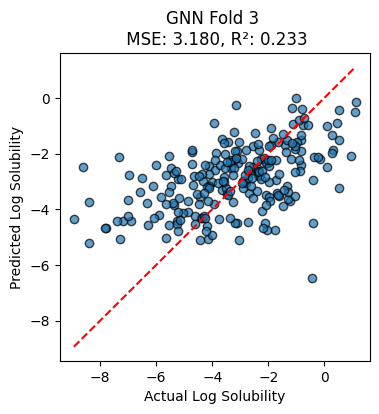

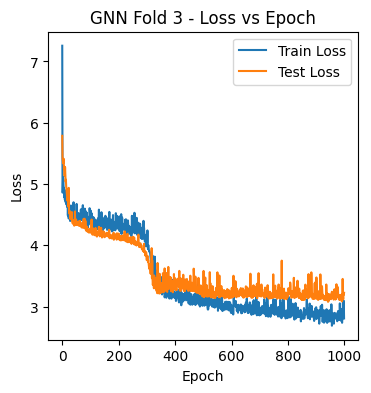

Fold 4
Epoch 0, Train Loss: 8.2048, Test Loss: 4.9721
Epoch 10, Train Loss: 4.8408, Test Loss: 4.4877
Epoch 20, Train Loss: 4.5600, Test Loss: 4.2479
Epoch 30, Train Loss: 4.3600, Test Loss: 4.1638
Epoch 40, Train Loss: 4.3088, Test Loss: 4.1260
Epoch 50, Train Loss: 4.2779, Test Loss: 4.0837
Epoch 60, Train Loss: 4.1986, Test Loss: 4.2269
Epoch 70, Train Loss: 4.2347, Test Loss: 4.1759
Epoch 80, Train Loss: 4.2591, Test Loss: 4.1577
Epoch 90, Train Loss: 4.2348, Test Loss: 4.1447
Epoch 100, Train Loss: 4.1689, Test Loss: 4.0974
Epoch 110, Train Loss: 4.1901, Test Loss: 4.0728
Epoch 120, Train Loss: 4.1856, Test Loss: 4.0011
Epoch 130, Train Loss: 4.0760, Test Loss: 4.1465
Epoch 140, Train Loss: 3.9549, Test Loss: 3.9395
Epoch 150, Train Loss: 3.8884, Test Loss: 3.7238
Epoch 160, Train Loss: 3.6876, Test Loss: 3.6786
Epoch 170, Train Loss: 3.7141, Test Loss: 3.3039
Epoch 180, Train Loss: 3.3128, Test Loss: 3.2291
Epoch 190, Train Loss: 3.3374, Test Loss: 3.4591
Epoch 200, Train Loss: 3

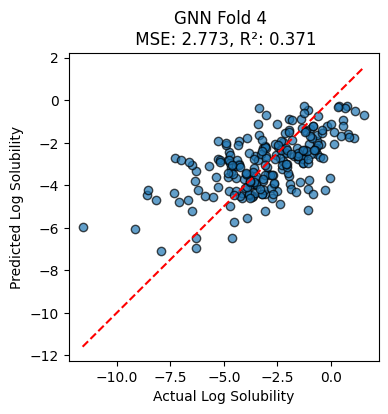

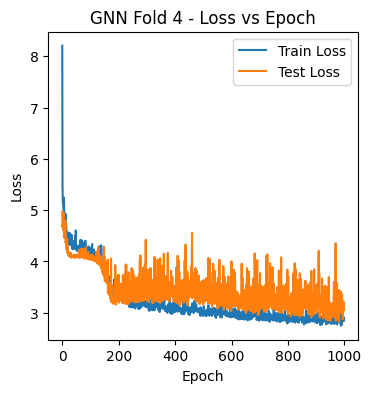

Fold 5
Epoch 0, Train Loss: 7.3473, Test Loss: 5.1795
Epoch 10, Train Loss: 4.9100, Test Loss: 4.2319
Epoch 20, Train Loss: 4.5927, Test Loss: 4.0346
Epoch 30, Train Loss: 4.4530, Test Loss: 3.9464
Epoch 40, Train Loss: 4.4223, Test Loss: 3.8735
Epoch 50, Train Loss: 4.3374, Test Loss: 3.8377
Epoch 60, Train Loss: 4.3602, Test Loss: 3.8830
Epoch 70, Train Loss: 4.5299, Test Loss: 3.6797
Epoch 80, Train Loss: 4.2300, Test Loss: 3.7131
Epoch 90, Train Loss: 4.3514, Test Loss: 3.6965
Epoch 100, Train Loss: 4.3795, Test Loss: 3.6592
Epoch 110, Train Loss: 4.4259, Test Loss: 3.7938
Epoch 120, Train Loss: 4.2719, Test Loss: 3.8559
Epoch 130, Train Loss: 4.1966, Test Loss: 3.6668
Epoch 140, Train Loss: 4.2292, Test Loss: 3.6812
Epoch 150, Train Loss: 4.2164, Test Loss: 3.7784
Epoch 160, Train Loss: 4.2585, Test Loss: 3.7670
Epoch 170, Train Loss: 4.2103, Test Loss: 3.9415
Epoch 180, Train Loss: 4.1507, Test Loss: 3.7697
Epoch 190, Train Loss: 4.2102, Test Loss: 3.8918
Epoch 200, Train Loss: 4

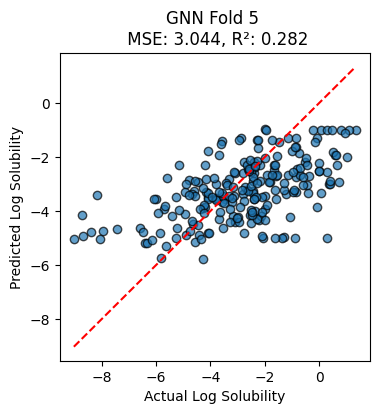

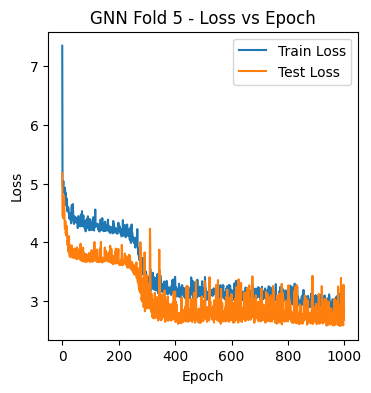

Average MSE: 3.148, Average R²: 0.278


In [13]:
# Define hyperparameters here
hidden_channels = 128
learning_rate = 0.001
num_epochs = 1000
batch_size = 32

mse_scores = []
r2_scores = []

for fold, (train_idx, test_idx) in enumerate(kf.split(graph_data_list)):
    print(f"Fold {fold + 1}")

    # Create train and test loaders
    train_dataset = [graph_data_list[i] for i in train_idx]
    test_dataset = [graph_data_list[i] for i in test_idx]
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize the model, optimizer, and loss function
    model = GNN(hidden_channels=hidden_channels)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()

    # Training loop
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, criterion)
        test_loss, _, _, _, _ = evaluate(model, test_loader, criterion)

        train_losses.append(train_loss)
        test_losses.append(test_loss)


        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # Evaluate the model
    _, mse, r2, y_true, y_pred = evaluate(model, test_loader, criterion)
    mse_scores.append(mse)
    r2_scores.append(r2)

    # Plot correlation between actual and predicted values
    plt.figure(figsize=(4, 4))
    plt.scatter(y_true, y_pred, edgecolor='k', alpha=0.7)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='r', linestyle='--')
    plt.title(f'GNN Fold {fold + 1} \n MSE: {mse:.3f}, R²: {r2:.3f}')
    plt.xlabel('Actual Log Solubility')
    plt.ylabel('Predicted Log Solubility')
    plt.show()

    # Plot loss vs epoch
    plt.figure(figsize=(4, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'GNN Fold {fold + 1} - Loss vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Print overall performance
print(f'Average MSE: {np.mean(mse_scores):.3f}, Average R²: {np.mean(r2_scores):.3f}')

